# Read data

In [14]:
import sys
from pathlib import Path
root_proj = Path("/Users/yk/Documents/Projects/Pre-PhD")

if str(root_proj/"src") not in sys.path:
    sys.path.append(str(root_proj/"src"))

In [15]:
import pandas as pd
from data_proc import convert_for_EV

year = 2023

chargelogs = pd.read_excel(root_proj / "DATA_SYSTEM_LIDL" / "Raw_chargelogs" / f"Chargelogs {year}.xlsx")
# convert the data frame
converted_df = convert_for_EV(chargelogs, bin=15)
converted_df.sample(20)

,Time,LFR3591EVCP01,LFR3591EVCP02,LFR3591EVCP03,LFR3591EVCP04,LFR3591EVCP05,Total
5490,2023-02-27 04:30:00,6.149112,0.000000,0.0,0.000000,0.000000,6.149112
25021,2023-09-18 15:15:00,0.000000,0.000000,0.0,6.905689,0.000000,6.905689
3965,2023-02-11 07:15:00,0.000000,3.891466,0.0,0.000000,0.000000,3.891466
19408,2023-07-22 04:00:00,0.000000,0.000000,0.0,1.448301,0.000000,1.448301
4211,2023-02-13 20:45:00,0.000000,3.361132,0.0,0.000000,0.000000,3.361132
22466,2023-08-23 00:30:00,4.359692,0.000000,0.0,2.736093,2.523802,9.619587
19690,2023-07-25 02:30:00,7.313501,0.000000,0.0,2.332585,5.380008,15.026093
957,2023-01-10 23:15:00,0.000000,5.636349,0.0,0.000000,0.000000,5.636349
12533,2023-05-11 13:15:00,0.000000,0.000000,0.0,1.198646,0.000000,1.198646
1902,2023-01-20 19:30:00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


## Splite train and test

In [ ]:
step = (60/15)*24*30*3 # three months
step = int(step)
df_train = converted_df.iloc[:-step]
df_test = converted_df.iloc[-step:]

## Plot

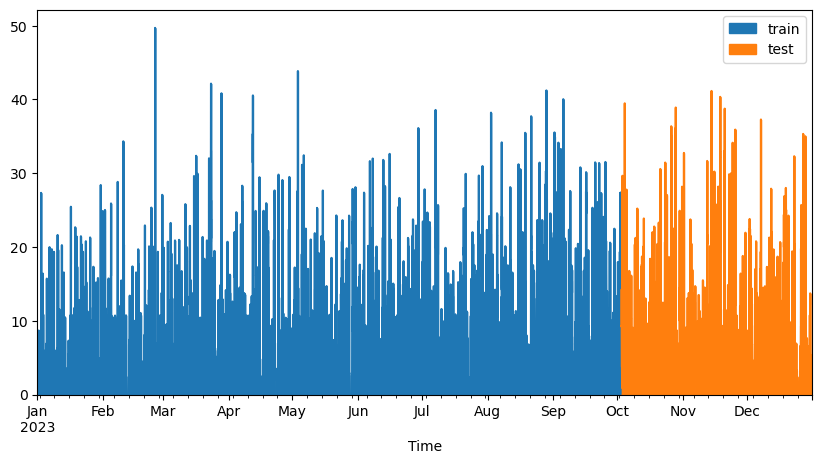

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
df_train.plot(ax=ax, label='train', x='Time', y='Total', kind='area')
df_test.plot(ax=ax, label='test', x='Time', y='Total', kind='area')
ax.legend()

plt.show()


# Training

In [ ]:
from skforecast.recursive import ForecasterRecursive
from skforecast.preprocessing import RollingFeatures
from sklearn.ensemble import RandomForestRegressor

forecaster = ForecasterRecursive(
    estimator = RandomForestRegressor(random_state=42, verbose=-1),
    lags = int((60/15)*24*7), # use previous one week
    window_features = RollingFeatures(stats=['mean'], window_sizes=int((60/15)*24))
)

In [ ]:
import joblib as jb
import json

output_dir = root_proj / "checkpoints" / "point01"

if not (output_dir / "log.json").is_file(): # first train
    output_dir.mkdir(parents=True, exist_ok=True)
    # training
    forecaster.fit(y=df_train['Total'], store_in_sample_residuals=True)
    # residuals = forecaster.in_sample_residuals  # 查看训练残差
    # save model
    jb.dump(forecaster, output_dir/"model.joblib")
    # log
    log = {
        "metadata": {
            "description": "recursive random forest regresion",
            "lags": int((60/15)*24*7),
            "window_features": {
                "type": "rolling",
                "stats": ["mean"],
                "window_size": int((60/15)*24)
            },
            "freq": "15min"
        },
        # "residuals": forecaster.in_sample_residuals
    }
    # save log
    with open(output_dir/"log.json", "w") as f:
        json.dump(log, f, indent=2)
    print("End of training")
else:
    # 加载模型 | load model
    forecaster = jb.load(output_dir/"model.joblib")
    # load log
    with open(output_dir/"log.json", "r") as f:
        log = json.load(f)
    print("Loaded")

Loaded
